# Add extra column with linear parameters to Planck chains

This notebook shows how to read an original chain from Planck (not in cup1d repo), and compute linear power parameters for each point in the chain.

Actually, the code is fairly slow, so it only does this for a handful of points in the chain. 

Heavier work is done with a python script in cup1d/scripts/add_linP_chains.py

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
from getdist import plots
from cup1d.planck import planck_chains
from cup1d.planck import add_linP_params
# because of black magic, getdist needs this strange order of imports
%matplotlib inline

### Read Planck 2018 chain

((0.2461608058922021, 0.3761089941077979),
 (2.9202071783619323, 3.4264598216380677))

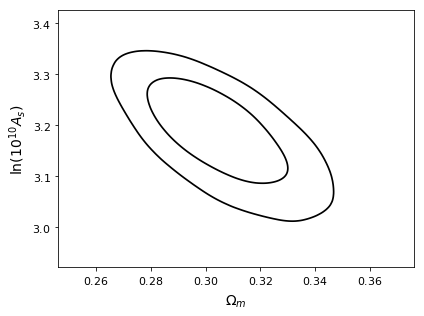

In [2]:
# by default the object below would use the chains provided in cup1d, but we want to access original chains here
root_dir=os.environ['PLANCK_CHAINS']
model='base'
data='plikHM_TT'
planck2018=planck_chains.get_planck_2018(model=model,data=data,root_dir=root_dir,linP_tag=None)
g = plots.getSinglePlotter()
g.plot_2d(planck2018['samples'], ['omegam', 'logA'])

In [3]:
# dramatically reduce sice of chain, for testing
samples=planck2018['samples'].copy()
thinning=10000
samples.thin(thinning)
Nsamp,Npar=samples.samples.shape
print('Thinned chains have {} samples and {} parameters'.format(Nsamp,Npar))

Thinned chains have 9 samples and 83 parameters


### For each element in the chain, compute setup CAMB object and compute linear power parameters

In [4]:
# if set to False, it will not compute parameters describing deviations from EdS (f_star,g_star)
z_evol=False

In [5]:
linP_params=[]
for i in range(Nsamp):
    verbose=(i%1==0)
    if verbose: print('sample point',i)
    params=samples.getParamSampleDict(i)
    linP_params.append(add_linP_params.get_linP_params(params,z_evol=z_evol,verbose=verbose))
    if verbose: print('linP params',linP_params[-1])

sample point 0
H0 = 6.9211E+01, Omega_bc = 2.8803E-01, A_s = 2.6280E-09, n_s = 9.7850E-01, alpha_s = 0.0000E+00
linP params {'Delta2_star': 0.4225964944593785, 'n_star': -2.2924409261020666, 'alpha_star': -0.21323064571349953}
sample point 1
H0 = 6.6570E+01, Omega_bc = 3.2521E-01, A_s = 2.2107E-09, n_s = 9.5738E-01, alpha_s = 0.0000E+00
linP params {'Delta2_star': 0.37518923960240547, 'n_star': -2.3055472204396317, 'alpha_star': -0.21716815061605396}
sample point 2
H0 = 6.9324E+01, Omega_bc = 2.8422E-01, A_s = 2.3683E-09, n_s = 9.7422E-01, alpha_s = 0.0000E+00
linP params {'Delta2_star': 0.3719763482075285, 'n_star': -2.297752848008025, 'alpha_star': -0.21268470324677174}
sample point 3
H0 = 6.8186E+01, Omega_bc = 3.0193E-01, A_s = 2.5972E-09, n_s = 9.7645E-01, alpha_s = 0.0000E+00
linP params {'Delta2_star': 0.43261200735607225, 'n_star': -2.2914849605637, 'alpha_star': -0.2146848015847482}
sample point 4
H0 = 6.6838E+01, Omega_bc = 3.1940E-01, A_s = 2.3329E-09, n_s = 9.6800E-01, alph

In [6]:
# setup numpy arrays with linP parameters
linP_DL2_star=np.array([linP_params[i]['Delta2_star'] for i in range(Nsamp)])
linP_n_star=np.array([linP_params[i]['n_star'] for i in range(Nsamp)])
linP_alpha_star=np.array([linP_params[i]['alpha_star'] for i in range(Nsamp)])
if z_evol:
    linP_f_star=np.array([linP_params[i]['f_star'] for i in range(Nsamp)])
    linP_g_star=np.array([linP_params[i]['g_star'] for i in range(Nsamp)])

In [7]:
# add new derived linP parameters 
samples.addDerived(linP_DL2_star,'linP_DL2_star',label='Ly\\alpha \\, \\Delta_\\ast')
samples.addDerived(linP_n_star,'linP_n_star',label='Ly\\alpha \\, n_\\ast')
samples.addDerived(linP_alpha_star,'linP_alpha_star',label='Ly\\alpha \\, \\alpha_\\ast')
if z_evol:
    samples.addDerived(linP_f_star,'linP_f_star',label='Ly\\alpha \\, f_\\ast')
    samples.addDerived(linP_g_star,'linP_g_star',label='Ly\\alpha \\, g_\\ast')

In [8]:
# get basic statistics for the new parameters
param_means=np.mean(samples.samples,axis=0)
param_vars=np.var(samples.samples,axis=0)
print('DL2_star mean = {} +/- {}'.format(param_means[Npar],np.sqrt(param_vars[Npar])))
print('n_star mean = {} +/- {}'.format(param_means[Npar+1],np.sqrt(param_vars[Npar+1])))
print('alpha_star mean = {} +/- {}'.format(param_means[Npar+2],np.sqrt(param_vars[Npar+2])))
if z_evol:
    print('f_star mean = {} +/- {}'.format(param_means[Npar+3],np.sqrt(param_vars[Npar+3])))
    print('g_star mean = {} +/- {}'.format(param_means[Npar+4],np.sqrt(param_vars[Npar+4])))

DL2_star mean = 0.4102252054200202 +/- 0.026955659404217538
n_star mean = -2.295681927973006 +/- 0.004321386106622263
alpha_star mean = -0.21474368374746847 +/- 0.001367095173705026


### Write extended chains to file

In [9]:
if z_evol:
    new_root='./test_zlinP'
else:
    new_root='./test_linP'
if (thinning > 1.0):
    new_root+='_'+str(thinning)
print('new root',new_root)
samples.saveAsText(root=new_root,make_dirs=True)

new root ./test_linP_10000


In [10]:
# Try reading the new file
from getdist import loadMCSamples
new_samples = loadMCSamples(new_root)
# get basic statistics for the new parameters
new_param_means=np.mean(new_samples.samples,axis=0)
new_param_vars=np.var(new_samples.samples,axis=0)
print('old DL2_star mean = {} +/- {}'.format(param_means[Npar],np.sqrt(param_vars[Npar])))
print('new DL2_star mean = {} +/- {}'.format(new_param_means[Npar],np.sqrt(new_param_vars[Npar])))

./test_linP_10000.txt
Removed no burn in
old DL2_star mean = 0.4102252054200202 +/- 0.026955659404217538
new DL2_star mean = 0.4102252053333333 +/- 0.026955659318146828
